# Default Payment Classification

## Table of contents
0. [Introduction](#0)
1. [Data splitting](#1)
2. [EDA](#2)
3. [Preprocessing and transformations](#3)
4. [Baseline model](#4)
5. [Linear models](#5)
6. [Different models](#6)
7. [Hyperparameter optimization](#7)
8. [Interpretation and feature importances](#8)
9. [Results on the test set](#9)
10. [Summary of the results](#10)

## Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import (
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
import altair as alt
import shap
from scipy.stats import loguniform
from sklearn.metrics import make_scorer, recall_score, f1_score
from sklearn.metrics import classification_report

<br><br>

## 0. Understand the dataset <a name="0"></a>
<hr>

**Our intuitions and thoughts:**
  1) We can first compare the amount of bill statements and the amount of previous payment, then look at repayment status. Customers have no or less default payment records will be less likely to make default payment for next month. 
  2) Usually the wealthier will get higher amount of given credit, `LIMIT_BAL`, so we assume these customers are less likely to make default payment for next month.
  3) Customers with higher education, lower number in `EDUCATION` (except 0 whose meaning is unknown), are all assumed to be less likely to make default payment for next month.
  4) As shown below, the dataset is imbalanced. We need to add `class_weight = "balanced"` to adjust it.
  5) There is no missing value, so no need to apply imputation.

In [2]:
uci_df = pd.read_csv("UCI_Credit_Card.csv")
uci_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [3]:
uci_df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [4]:
uci_df.rename(columns={"default.payment.next.month": "default"}, inplace=True)

In [5]:
uci_df["default"].value_counts()

0    23364
1     6636
Name: default, dtype: int64

<br><br>

## 1. Data splitting <a name="1"></a>
<hr>

In [6]:
train_df, test_df = train_test_split(uci_df, test_size=0.3)
train_df.shape

(21000, 25)

<br><br>

## 2. EDA <a name="2"></a>
<hr>

**1. Summary statistics:**
- There is no missing data here in this dataset, thus no need to impute missing values.
- The target variable `default` has class imbalance, we need to consider this when building the model and the scoring metrics.

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21000 entries, 3373 to 21303
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         21000 non-null  int64  
 1   LIMIT_BAL  21000 non-null  float64
 2   SEX        21000 non-null  int64  
 3   EDUCATION  21000 non-null  int64  
 4   MARRIAGE   21000 non-null  int64  
 5   AGE        21000 non-null  int64  
 6   PAY_0      21000 non-null  int64  
 7   PAY_2      21000 non-null  int64  
 8   PAY_3      21000 non-null  int64  
 9   PAY_4      21000 non-null  int64  
 10  PAY_5      21000 non-null  int64  
 11  PAY_6      21000 non-null  int64  
 12  BILL_AMT1  21000 non-null  float64
 13  BILL_AMT2  21000 non-null  float64
 14  BILL_AMT3  21000 non-null  float64
 15  BILL_AMT4  21000 non-null  float64
 16  BILL_AMT5  21000 non-null  float64
 17  BILL_AMT6  21000 non-null  float64
 18  PAY_AMT1   21000 non-null  float64
 19  PAY_AMT2   21000 non-null  float64
 20  PAY

In [8]:
train_df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,...,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,15039.577381,167102.365714,1.602952,1.857667,1.550571,35.486476,-0.017000,-0.136762,-0.164571,-0.217381,...,43024.364476,40002.416619,38553.573286,5621.883333,5.860851e+03,5228.110905,4765.267524,4731.722952,5146.844762,0.220524
std,8659.951708,129388.104681,0.489298,0.793431,0.520374,9.187866,1.128763,1.202827,1.204094,1.177933,...,64156.790078,60431.516526,59151.863682,17029.070462,2.200113e+04,17543.369378,15530.502006,15065.811990,17274.864005,0.414610
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7589.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2315.750000,1725.250000,1225.000000,988.000000,8.360000e+02,390.000000,291.000000,237.750000,118.750000,0.000000
50%,15071.000000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19043.000000,18092.500000,17062.000000,2090.000000,2.000500e+03,1800.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,22511.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,53232.000000,49552.250000,48538.750000,5000.000000,5.000000e+03,4500.000000,4000.000000,4001.000000,4000.000000,0.000000
max,30000.000000,800000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,7.000000,8.000000,8.000000,...,706864.000000,823540.000000,699944.000000,873552.000000,1.227082e+06,889043.000000,621000.000000,426529.000000,443001.000000,1.000000


In [9]:
train_df["default"].value_counts(normalize=True)

0    0.779476
1    0.220524
Name: default, dtype: float64

<br><br>

**2. Visualization:**
- Correlation matrix    
  According to the correlation matrix, there is high multicolinearity between `BILL_AMT1` to `BILL_AMT6`, `PAY_0` to `PAY_6` and `MARRIAGE` and `AGE`. We can handle this with regularization.
    
- Exploratory data visualizations
    - Second plot    
      There is a clear tendency that those who have credit card default tend to have longer payment delay (higher `PAY_0` value). `PAY_0` may be an important feature in our model.
      
    - Third plot    
      This plot shows the amount of payment VS amount of bill for July, 2005. We can see that for most data in class 1, the amount of bill is higher than the payment.      

In [10]:
cor = train_df.corr()
corr_df = cor.stack().reset_index(name='corr')

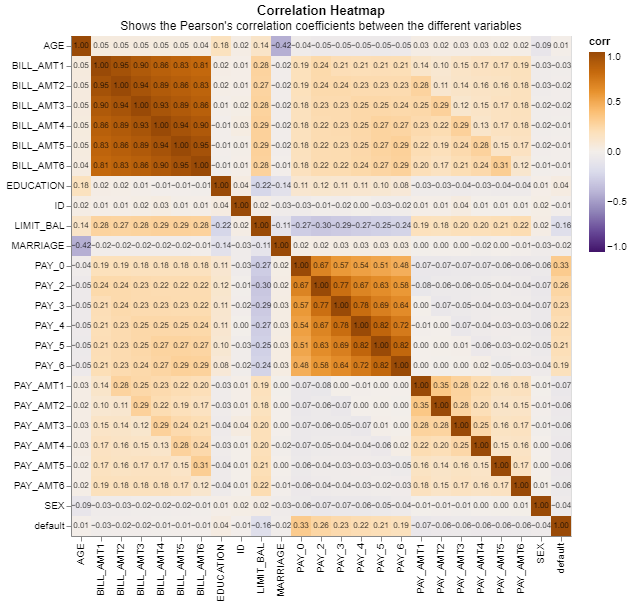

In [11]:
alt.renderers.enable('mimetype')

title = alt.TitleParams(
        text="Correlation Heatmap",
        subtitle="Shows the Pearson's correlation coefficients between the different variables")

plot = alt.Chart(corr_df, title=title).mark_rect().encode(
    x=alt.X('level_0', title=''),
    y=alt.Y('level_1', title=''),
    color=alt.Color('corr', scale=alt.Scale(domain=(-1, 1), scheme='purpleorange'))
)

text = plot.mark_text(
    size=8
).encode(
    text=alt.Text('corr', format=".2f"),
    color=alt.value('black')
)

plot + text

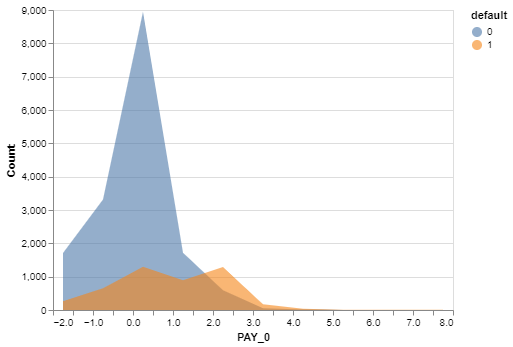

In [12]:
alt.data_transformers.enable('data_server')

train_df['default'] = train_df['default'].astype("category")
alt.Chart(train_df).mark_area(opacity=0.6).encode(
    x=alt.X('PAY_0', bin=alt.Bin(maxbins=30), title="PAY_0"),
    y=alt.Y('count()', stack=False, title="Count"),
    color=alt.Color('default')
)

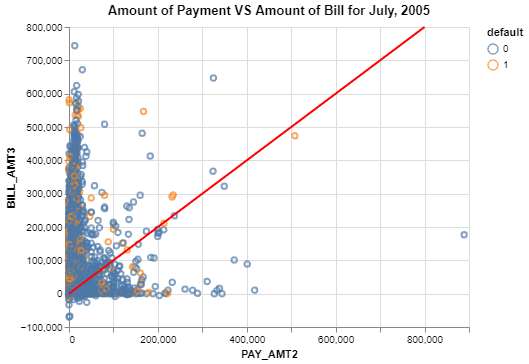

In [13]:
line = pd.DataFrame({
    'x': [0, 800000],
    'y': [0, 800000],
})

line_plot = alt.Chart(line).mark_line(color='red').encode(
    x='x',
    y='y'
)
alt.Chart(
    train_df,
    title="Amount of Payment VS Amount of Bill for July, 2005"
).mark_point().encode(
        alt.X("PAY_AMT3", title="PAY_AMT2"),
        alt.Y("BILL_AMT2", title="BILL_AMT3"),
        color="default"
) + line_plot

**3. Evaluation metrics:**    
Since false negative is more important for us in this question, we choose `recall` and `f1` and focus on `recall`.

In [14]:
recall_scorer = make_scorer(recall_score, average="macro")
f1_scorer = make_scorer(f1_score, average="macro")

scoring_metrics = {"recall": recall_scorer, "f1": f1_scorer}

<br><br>

## 3. Preprocessing and transformations <a name="3"></a>
<hr>

In [15]:
train_df["EDUCATION"].value_counts()

2    9806
1    7372
3    3495
5     198
4      78
6      40
0      11
Name: EDUCATION, dtype: int64

In [16]:
train_df["PAY_0"].value_counts()

 0    10245
-1     3972
 1     2610
-2     1968
 2     1879
 3      228
 4       50
 5       21
 8       13
 6        8
 7        6
Name: PAY_0, dtype: int64

_- We treat `EDUCATION` as a categorical feature instead of an ordinal feature, since there are a lot of values are 0, 5, or 6 which represents unknown. We just keep it as it is for now._

_- We decide to treat `PAY_0` to `PAY_5` as numeric features since the values are just representing the number of months delayed for the payments. According to other documentations, `-2` means no consumption. We will ignore it for now._

In [17]:
drop_features = ["ID"]
binary_features = ["SEX"]
categorical_features = ['EDUCATION', 'MARRIAGE']
target = "default"
numeric_features = list(
    set(train_df.columns)
    - set(drop_features)
    - set(binary_features)
    - set(categorical_features)
    - set([target])
)
assert train_df.columns.shape[0] == len(
    drop_features
    + binary_features
    + categorical_features
    + numeric_features
    + [target]
)

In [18]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(drop="if_binary", dtype="int"), binary_features),
    (OneHotEncoder(handle_unknown="ignore", dtype="int"), categorical_features),
    ("drop", drop_features),
)

In [19]:
X_train, y_train = train_df.drop(columns=[target]), train_df[target]
X_test, y_test = test_df.drop(columns=[target]), test_df[target]

<br><br>

## 4. Baseline model -- DummyClassifier<a name="4"></a>
<hr>

In [20]:
results = {}

In [21]:
# Adopted from lecture notes
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [22]:
dummy = DummyClassifier(strategy="stratified")
results['Dummy'] = mean_std_cross_val_scores(
    dummy, X_train, y_train,
    return_train_score=True,
    scoring=scoring_metrics)

pd.DataFrame(results).T

,fit_time,score_time,test_recall,train_recall,test_f1,train_f1
Dummy,0.007 (+/- 0.003),0.012 (+/- 0.004),0.499 (+/- 0.005),0.501 (+/- 0.004),0.499 (+/- 0.005),0.501 (+/- 0.004)


<br><br>

## 5. Linear model -- Logistic Regression <a name="5"></a>
<hr>

In [23]:
pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(max_iter=2000, class_weight="balanced")
)

results['Logistic regression'] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train,
    return_train_score=True,
    scoring=scoring_metrics)

pd.DataFrame(results).T

,fit_time,score_time,test_recall,train_recall,test_f1,train_f1
Dummy,0.007 (+/- 0.003),0.012 (+/- 0.004),0.499 (+/- 0.005),0.501 (+/- 0.004),0.499 (+/- 0.005),0.501 (+/- 0.004)
Logistic regression,0.634 (+/- 0.092),0.023 (+/- 0.002),0.671 (+/- 0.008),0.674 (+/- 0.002),0.623 (+/- 0.008),0.626 (+/- 0.003)


In [24]:
param_dist = {
    "logisticregression__C": loguniform(1e-5, 1e5)
}

In [25]:
random_search = RandomizedSearchCV(
    pipe_lr,
    param_dist,
    n_iter=20,
    verbose=1,
    n_jobs=-1,
    scoring=scoring_metrics,
    refit="recall"
)
random_search.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [26]:
random_search.best_params_

{'logisticregression__C': 0.13023865302947588}

In [27]:
pipe_best_lr = random_search.best_estimator_

In [28]:
results['Logistic regression_tuned'] = mean_std_cross_val_scores(
    pipe_best_lr, X_train, y_train,
    return_train_score=True,
    scoring=scoring_metrics)

pd.DataFrame(results).T

,fit_time,score_time,test_recall,train_recall,test_f1,train_f1
Dummy,0.007 (+/- 0.003),0.012 (+/- 0.004),0.499 (+/- 0.005),0.501 (+/- 0.004),0.499 (+/- 0.005),0.501 (+/- 0.004)
Logistic regression,0.634 (+/- 0.092),0.023 (+/- 0.002),0.671 (+/- 0.008),0.674 (+/- 0.002),0.623 (+/- 0.008),0.626 (+/- 0.003)
Logistic regression_tuned,0.274 (+/- 0.033),0.017 (+/- 0.003),0.672 (+/- 0.007),0.675 (+/- 0.003),0.625 (+/- 0.008),0.627 (+/- 0.004)


- For this dataset, we want to minimize False Negatives. Therefore, we prefer models with higher recall scores.
- The default logistic regression seems underfit. The train and test recalls are both low. 
- The tuned logistic regression performs a little bit better than the default one for recall scores. F1 score gets higher as well.

<br><br>

## 6. Different models <a name="6"></a>
<hr>

In [29]:
ratio = np.bincount(y_train)[0] /  np.bincount(y_train)[1]
ratio

3.5346577413085725

In [30]:
pipe_knn = make_pipeline(preprocessor, KNeighborsClassifier())
pipe_nb = make_pipeline(preprocessor, BernoulliNB())
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(class_weight="balanced"))
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(scale_pos_weight=ratio))
pipe_xgb = make_pipeline(
    preprocessor,
    XGBClassifier(
        scale_pos_weight=ratio,
        eval_metric="logloss",
        verbosity=0,
        use_label_encoder=False
    )
)


models = {
    "KNN": pipe_knn,
    "Naive Bayes": pipe_nb,
    "Random forest": pipe_rf,
    "LightGBM": pipe_lgbm,
    "XGBoost": pipe_xgb
}

In [31]:
for name, model in models.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train,
        return_train_score=True,
        scoring=scoring_metrics
    )

pd.DataFrame(results).T

,fit_time,score_time,test_recall,train_recall,test_f1,train_f1
Dummy,0.007 (+/- 0.003),0.012 (+/- 0.004),0.499 (+/- 0.005),0.501 (+/- 0.004),0.499 (+/- 0.005),0.501 (+/- 0.004)
Logistic regression,0.634 (+/- 0.092),0.023 (+/- 0.002),0.671 (+/- 0.008),0.674 (+/- 0.002),0.623 (+/- 0.008),0.626 (+/- 0.003)
Logistic regression_tuned,0.274 (+/- 0.033),0.017 (+/- 0.003),0.672 (+/- 0.007),0.675 (+/- 0.003),0.625 (+/- 0.008),0.627 (+/- 0.004)
KNN,0.044 (+/- 0.018),2.042 (+/- 0.357),0.637 (+/- 0.009),0.713 (+/- 0.004),0.653 (+/- 0.011),0.740 (+/- 0.004)
Naive Bayes,0.052 (+/- 0.004),0.021 (+/- 0.004),0.581 (+/- 0.009),0.581 (+/- 0.002),0.569 (+/- 0.009),0.569 (+/- 0.001)
Random forest,4.614 (+/- 0.177),0.133 (+/- 0.009),0.647 (+/- 0.007),1.000 (+/- 0.000),0.671 (+/- 0.009),0.999 (+/- 0.000)
LightGBM,0.468 (+/- 0.036),0.041 (+/- 0.004),0.711 (+/- 0.009),0.811 (+/- 0.004),0.686 (+/- 0.008),0.772 (+/- 0.004)
XGBoost,2.933 (+/- 0.112),0.031 (+/- 0.004),0.698 (+/- 0.011),0.905 (+/- 0.004),0.682 (+/- 0.011),0.862 (+/- 0.005)


- According to the results above, we can see that RandomForest overfits the most. Train scores for all scoring metrics equal or nearly equal to 1, while the test scores are much lower.
- XGBoost also overfits. The test recall is about half of the train recall.
- Considering the recall score and fit time, LightGBM performs the best.

<br><br>

## 7. Hyperparameter optimization <a name="7"></a>
<hr>

In [32]:
param_dist_dict = {
    "KNN": {
        "kneighborsclassifier__n_neighbors": np.arange(1, 100, 10),
    },
    "Naive Bayes": {
        "bernoullinb__alpha": loguniform(1e-3, 1e5)
    },
    "LightGBM": {
        "lgbmclassifier__n_estimators":  np.arange(1, 1000, 100),
        "lgbmclassifier__max_depth":  np.arange(1, 100, 10),
        "lgbmclassifier__learning_rate": loguniform(1e-5, 1e5)
    }
}

In [33]:
pipe_best = {}
score_best = {}

for name, param_dist in param_dist_dict.items():
    random_search = RandomizedSearchCV(
        models[name],
        param_distributions=param_dist,
        n_iter=10,
        verbose=1,
        n_jobs=-1,
        scoring=scoring_metrics,
        refit="recall"
    )
    random_search.fit(X_train, y_train)
    pipe_best[name] = random_search.best_estimator_
    score_best[name] = random_search.best_score_
    results[name + '_tuned'] = mean_std_cross_val_scores(
        pipe_best[name], X_train, y_train,
        return_train_score=True,
        scoring=scoring_metrics
    )

pd.DataFrame(results).T

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


,fit_time,score_time,test_recall,train_recall,test_f1,train_f1
Dummy,0.007 (+/- 0.003),0.012 (+/- 0.004),0.499 (+/- 0.005),0.501 (+/- 0.004),0.499 (+/- 0.005),0.501 (+/- 0.004)
Logistic regression,0.634 (+/- 0.092),0.023 (+/- 0.002),0.671 (+/- 0.008),0.674 (+/- 0.002),0.623 (+/- 0.008),0.626 (+/- 0.003)
Logistic regression_tuned,0.274 (+/- 0.033),0.017 (+/- 0.003),0.672 (+/- 0.007),0.675 (+/- 0.003),0.625 (+/- 0.008),0.627 (+/- 0.004)
KNN,0.044 (+/- 0.018),2.042 (+/- 0.357),0.637 (+/- 0.009),0.713 (+/- 0.004),0.653 (+/- 0.011),0.740 (+/- 0.004)
Naive Bayes,0.052 (+/- 0.004),0.021 (+/- 0.004),0.581 (+/- 0.009),0.581 (+/- 0.002),0.569 (+/- 0.009),0.569 (+/- 0.001)
Random forest,4.614 (+/- 0.177),0.133 (+/- 0.009),0.647 (+/- 0.007),1.000 (+/- 0.000),0.671 (+/- 0.009),0.999 (+/- 0.000)
LightGBM,0.468 (+/- 0.036),0.041 (+/- 0.004),0.711 (+/- 0.009),0.811 (+/- 0.004),0.686 (+/- 0.008),0.772 (+/- 0.004)
XGBoost,2.933 (+/- 0.112),0.031 (+/- 0.004),0.698 (+/- 0.011),0.905 (+/- 0.004),0.682 (+/- 0.011),0.862 (+/- 0.005)
KNN_tuned,0.037 (+/- 0.003),2.018 (+/- 0.216),0.644 (+/- 0.011),0.672 (+/- 0.005),0.665 (+/- 0.013),0.699 (+/- 0.006)
Naive Bayes_tuned,0.049 (+/- 0.003),0.022 (+/- 0.004),0.580 (+/- 0.008),0.581 (+/- 0.002),0.569 (+/- 0.009),0.569 (+/- 0.001)


- The tuned LightGBM is the best model, with the highest recall 0.712 and highest f1 score 0.692.
- We decided to drop RandomForest and XGBoost because the tuned models were still overfitting while they took a very long time to run. 

<br><br>

## 8. Feature importances and interpretation <a name="8"></a>
<hr>

In [34]:
preprocessor.fit(X_train, y_train);

In [35]:
feature_names = (
    numeric_features
    + list(
        pipe_best['LightGBM'].named_steps["columntransformer"]
        .named_transformers_["onehotencoder-1"]
        .get_feature_names_out()
    )
    + list(
        pipe_best['LightGBM'].named_steps["columntransformer"]
        .named_transformers_["onehotencoder-2"]
        .get_feature_names_out()
    )
)

In [36]:
X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=feature_names,
    index=X_train.index
)
X_train_enc.head()

,BILL_AMT5,PAY_AMT5,PAY_0,BILL_AMT6,PAY_AMT4,PAY_2,PAY_AMT1,BILL_AMT1,BILL_AMT4,PAY_4,...,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
3373,-0.662508,-0.314078,-1.756833,-0.652346,-0.306840,-1.549086,-0.330142,-0.693004,-0.671143,-1.513381,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5728,-0.102390,7.376365,-0.870886,1.306844,1.871313,-0.717691,-0.110395,-0.651326,0.406867,-0.664416,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12761,-0.515264,-0.291510,0.015061,-0.498653,-0.281084,0.113703,-0.262609,-0.009985,-0.536517,0.184549,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3242,-0.661962,-0.314078,1.786955,-0.651788,-0.306840,1.776492,-0.330142,-0.657997,-0.670629,-1.513381,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8347,0.049819,-0.310228,0.015061,-0.454765,5.176371,-0.717691,2.082730,-0.398943,-1.208433,-1.513381,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [37]:
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index
)
X_test_enc.head()

,BILL_AMT5,PAY_AMT5,PAY_0,BILL_AMT6,PAY_AMT4,PAY_2,PAY_AMT1,BILL_AMT1,BILL_AMT4,PAY_4,...,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
3820,-0.587413,-0.312020,0.015061,-0.588120,-0.113474,0.113703,0.022205,-0.648339,-0.647217,1.882479,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
28378,1.687464,0.216939,0.015061,1.737120,0.143897,0.113703,0.257103,1.689730,1.755111,0.184549,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
13794,-0.643925,0.210965,-1.756833,-0.503218,-0.236654,-1.549086,-0.330142,-0.692103,-0.670629,-1.513381,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
20009,-0.641376,-0.314078,-1.756833,-0.651788,-0.226738,-1.549086,0.144058,-0.665023,-0.644583,-1.513381,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1294,-0.557759,-0.314078,0.015061,-0.635271,0.098630,0.113703,-0.243700,-0.221715,-0.648807,-0.664416,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [38]:
pipe_best['LightGBM'].fit(X_train, y_train);

In [39]:
lgbm_explainer = shap.TreeExplainer(pipe_best['LightGBM'].named_steps["lgbmclassifier"])
train_lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [40]:
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc[:100])

In [41]:
shap.initjs()

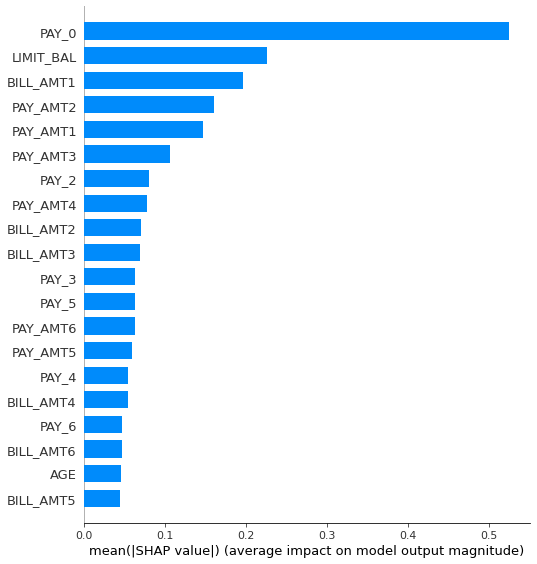

In [42]:
shap.summary_plot(train_lgbm_shap_values[1], X_train_enc, plot_type="bar")

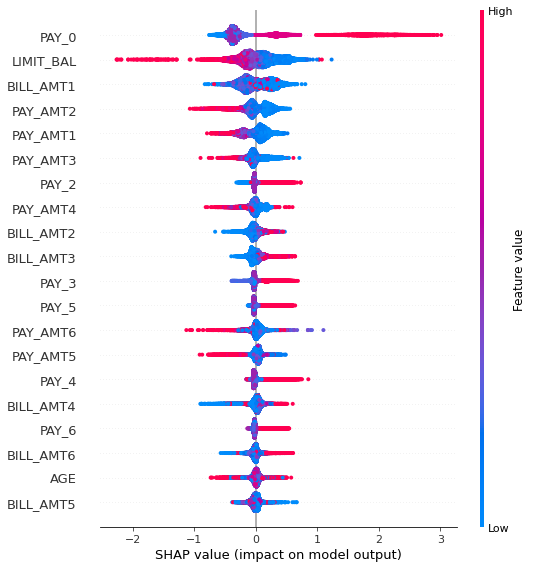

In [43]:
shap.summary_plot(train_lgbm_shap_values[1], X_train_enc)

The selected model is the tuned LightGBM.
- The features are ranked in descending order of feature importances. The second plot also shows the direction of how the features are going to drive the prediction.
- From the plots above, we can see that `PAY_0` is the most important feature. The higher value of `PAY_0` seems to have higher SHAP value for class1.

<br><br>

## 9. Results on the test set <a name="9"></a>
<hr>

**1. The test score when using our best performing model on test data:**

In [44]:
recall_score(y_test, pipe_best['LightGBM'].predict(X_test), average="macro")

0.7074559847700264

In [45]:
print(
    classification_report(
        y_test, pipe_best['LightGBM'].predict(X_test), target_names=["non-default", "default"]
    )
)

              precision    recall  f1-score   support

 non-default       0.88      0.81      0.84      6995
     default       0.47      0.61      0.53      2005

    accuracy                           0.76      9000
   macro avg       0.68      0.71      0.69      9000
weighted avg       0.79      0.76      0.77      9000



**2. Take one test prediction and explain with SHAP force plots:**

In [46]:
X_train_enc = X_train_enc.round(3)
X_test_enc = X_test_enc.round(3)

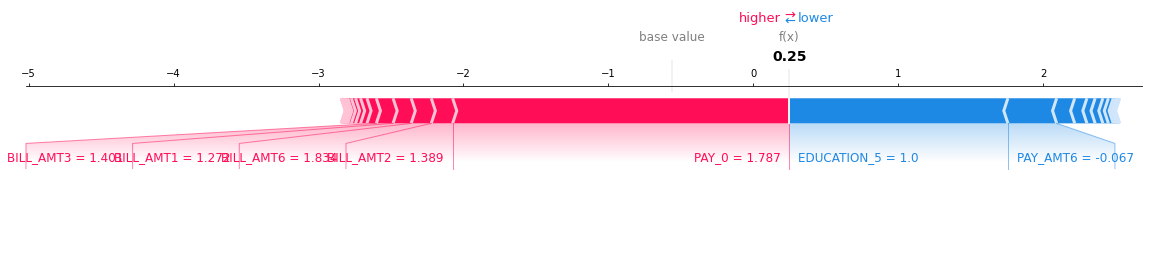

In [47]:
shap.force_plot(
    lgbm_explainer.expected_value[1],
    test_lgbm_shap_values[1][8],
    X_test_enc.iloc[8, :],
    matplotlib=True,
)

In [48]:
lgbm_explainer.expected_value

[0.5630307395764689, -0.5630307395764689]

**Test predictions**
- Everything is with respect to class 1, default payment for next month.
- The plots above show the forces that drive the prediction. The red features are the ones push the prediction to a higher value, and the blue ones are pushing the prediction to a lower value.

- In this case, the base value for class 1, default payment, is -0.563.

- For this example, the raw model score is 0.25 > base value. It is predicted as class 1, default payment for next month. Some of the forces driving the prediction towards higher value are:
    - a positive value for `PAY_0`. This makes sense! The longer the payment delay leads to higher SHAP value and more tendency to be predicted as default payment.
    - a positive value for `BILL_AMT1`, `BILL_AMT2`, `BILL_AMT3`, `BILL_AMT6`. This also makes sense. As the default payment cannot be possible if there is no bill statement for that month.

<br><br>

## 10. Summary of results <a name="10"></a>
<hr>

**1. Summary of important results**    

The test score using tuned LightGBM is **0.71**.

Model |Validation Recall Score | Training Recall Score | Validation f1 Score | Training f1 Score |
-----------|      ------------|------------|---------|------|
Logistic regression (tuned)  |  0.672   | 0.675   | 0.625 | 0.627 |
KNN (tuned)   |  0.644 |  0.672  | 0.665 | 0.699 |
Naive Bayes (tuned)  | 0.580    | 0.581  | 0.569 | 0.569 |
LightGBM (tuned)  | 0.712 |  0.856  | 0.692  | 0.813 |

**2. Conclusion:**
- In this study, we compares 6 classification models in supervised machine learning that may be useful for credit card default. Since we want to detect as many "real" default cases as possible, we choose to optimize recall score when we do hyperparameter optimization and model comparison.
- After hyperparameter optimization, LightGBM has the highest validation recall score (0.712) and the highest validation f1 score (0.692). Besides, LightGBM is also very fast. Therefore, we believe `LightGBM` is the optimal model for credit card default classification.


**3. Other ideas:**
- About feature engineering:
    - Difference between `BILL_AMT`s and `PAY_AMT`s may be a good feature. We can add this feature and see if the performance can improve.
    - There are many time-series features in this data set. For example, `PAY_0` to `PAY_6`, `BILL_AMT1` to `BILL_AMT6` and `PAY_AMT1` to `PAY_AMT6`. We may consider this time-series effect when we do feature engineering.
    
- Feature selection may also help improving the prediction accuracy.

<br><br>

<br><br>